## Warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [72]:
import polars as pl
import pandas as pd
import pygwalker as pyg
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import polars.selectors as cs
# from strip_markdown import strip_markdown
from janitor.polars import clean_names
from ydata_profiling import ProfileReport
from scipy.stats.contingency import association
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE , ADASYN , BorderlineSMOTE , KMeansSMOTE , SVMSMOTE , SMOTENC , SMOTEN
from sklearn.manifold import TSNE 
import altair as alt
# import buckaroo
import os


# Dataset Deals

In [4]:
df = pl.read_csv("data/Project_Phase1.csv")
Pandas_df = pd.read_csv("data/Project_Phase1.csv")

In [5]:
df.shape

(14036, 31)

In [6]:
df.schema

Schema([('syn_error_rate', Float64),
        ('connection_time', Int64),
        ('destination_same_source_port_rate', Float64),
        ('destination_different_server_rate', Float64),
        ('connection_status', String),
        ('connection_count', Int64),
        ('destination_server_different_host_rate', Float64),
        ('suspicious_activity', Int64),
        ('protocol', String),
        ('server_different_host_rate', Float64),
        ('destination_server_syn_error_rate', Float64),
        ('destination_host_server_count', Int64),
        ('destination_same_server_rate', Float64),
        ('fragment_errors', Int64),
        ('compromised_count', Int64),
        ('source_bytes', Int64),
        ('service_type', String),
        ('destination_syn_error_rate', Float64),
        ('same_server_rate', Float64),
        ('reset_error_rate', Float64),
        ('server_request_count', Int64),
        ('destination_server_reset_error_rate', Float64),
        ('server_reset_error_rate',

In [7]:
df = clean_names(df = df , case_type='lower', remove_special=True, strip_accents=True , strip_underscores=True , truncate_limit=None)

In [9]:
df.null_count()

syn_error_rate,connection_time,destination_same_source_port_rate,destination_different_server_rate,connection_status,connection_count,destination_server_different_host_rate,suspicious_activity,protocol,server_different_host_rate,destination_server_syn_error_rate,destination_host_server_count,destination_same_server_rate,fragment_errors,compromised_count,source_bytes,service_type,destination_syn_error_rate,same_server_rate,reset_error_rate,server_request_count,destination_server_reset_error_rate,server_reset_error_rate,server_syn_error_rate,destination_bytes,guest_login,authentication_status,destination_host_count,destination_reset_error_rate,different_server_rate,class
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df.select(cs.numeric()).describe()

statistic,syn_error_rate,connection_time,destination_same_source_port_rate,destination_different_server_rate,connection_count,destination_server_different_host_rate,suspicious_activity,server_different_host_rate,destination_server_syn_error_rate,destination_host_server_count,destination_same_server_rate,fragment_errors,compromised_count,source_bytes,destination_syn_error_rate,same_server_rate,reset_error_rate,server_request_count,destination_server_reset_error_rate,server_reset_error_rate,server_syn_error_rate,destination_bytes,guest_login,authentication_status,destination_host_count,destination_reset_error_rate,different_server_rate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.039788,184.191294,0.122315,0.044255,28.048019,0.025829,0.221288,0.122144,0.032572,182.678755,0.783955,0.001567,0.393346,11341.807922,0.039907,0.94019,0.048265,27.400328,0.048468,0.049172,0.037901,4226.110074,0.012183,0.681177,151.48625,0.050431,0.032923
"""std""",0.183392,1448.60408,0.257433,0.135233,63.798968,0.07139,2.327768,0.266557,0.168483,97.214193,0.348346,0.06751,13.949886,169682.168932,0.180893,0.211918,0.211091,60.297916,0.20034,0.211871,0.179243,68334.655301,0.109706,0.466037,101.76511,0.203809,0.151932
"""min""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,93.0,0.65,0.0,0.0,78.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,72.0,0.0,0.0,43.0,0.0,0.0
"""50%""",0.0,0.0,0.01,0.0,5.0,0.0,0.0,0.0,0.0,254.0,1.0,0.0,0.0,229.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,347.0,0.0,1.0,168.0,0.0,0.0
"""75%""",0.0,0.0,0.08,0.02,15.0,0.03,0.0,0.1,0.0,255.0,1.0,0.0,0.0,323.0,0.0,1.0,0.0,18.0,0.0,0.0,0.0,1924.0,0.0,1.0,255.0,0.0,0.0
"""max""",1.0,41476.0,1.0,1.0,511.0,1.0,77.0,1.0,1.0,255.0,1.0,3.0,884.0,7.665876e6,1.0,1.0,1.0,511.0,1.0,1.0,1.0,5.131424e6,1.0,1.0,255.0,1.0,1.0


In [11]:
# from buckaroo import enable; enable()
df.select(cs.string()).describe()

statistic,connection_status,protocol,service_type,class
str,str,str,str,str
"""count""","""14036""","""14036""","""14036""","""14036"""
"""null_count""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null
"""std""",null,null,null,null
"""min""","""OTH""","""icmp""","""IRC""","""anomaly"""
"""25%""",null,null,null,null
"""50%""",null,null,null,null
"""75%""",null,null,null,null
"""max""","""SF""","""udp""","""whois""","""normal"""


In [12]:
df.columns

['syn_error_rate',
 'connection_time',
 'destination_same_source_port_rate',
 'destination_different_server_rate',
 'connection_status',
 'connection_count',
 'destination_server_different_host_rate',
 'suspicious_activity',
 'protocol',
 'server_different_host_rate',
 'destination_server_syn_error_rate',
 'destination_host_server_count',
 'destination_same_server_rate',
 'fragment_errors',
 'compromised_count',
 'source_bytes',
 'service_type',
 'destination_syn_error_rate',
 'same_server_rate',
 'reset_error_rate',
 'server_request_count',
 'destination_server_reset_error_rate',
 'server_reset_error_rate',
 'server_syn_error_rate',
 'destination_bytes',
 'guest_login',
 'authentication_status',
 'destination_host_count',
 'destination_reset_error_rate',
 'different_server_rate',
 'class']

In [8]:
df = df.rename({"class": "target"})

In [10]:
profile = ProfileReport(Pandas_df, title="Pred-Sus-Act Report" , lazy=True , explorative=True , tsmode=True)

In [ ]:
profile.to_file("data/report.html")

In [11]:
del Pandas_df
del profile

## Extra Visuals

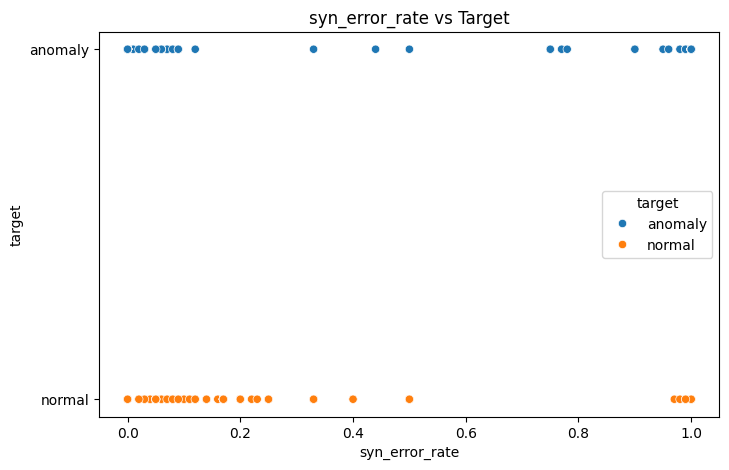

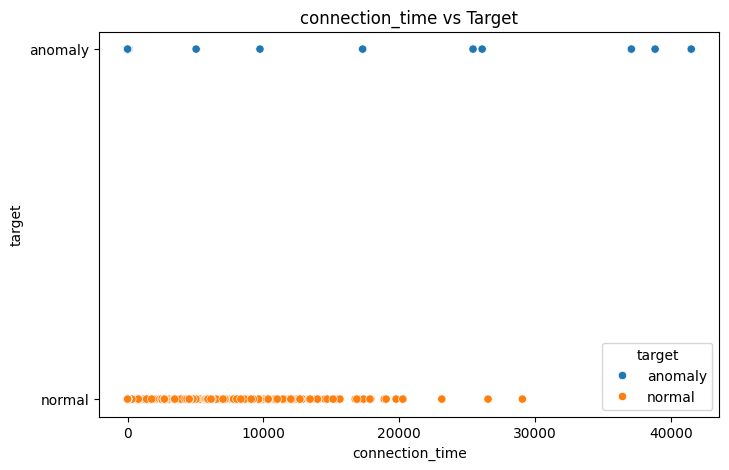

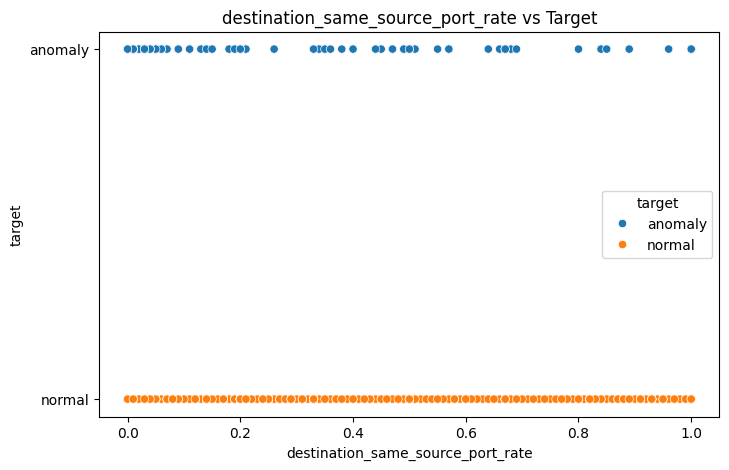

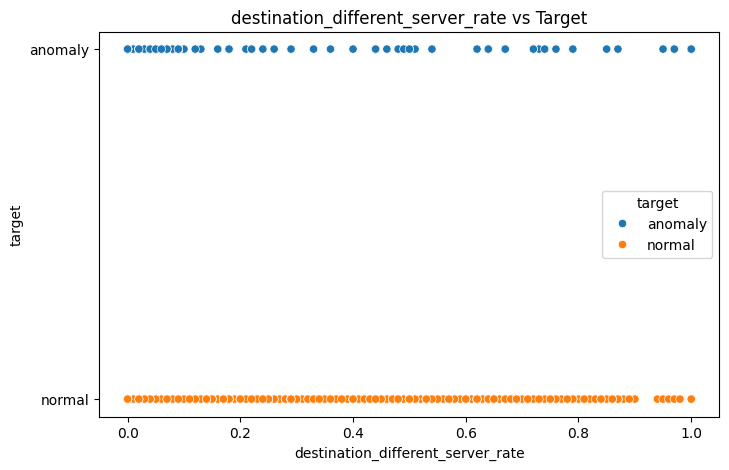

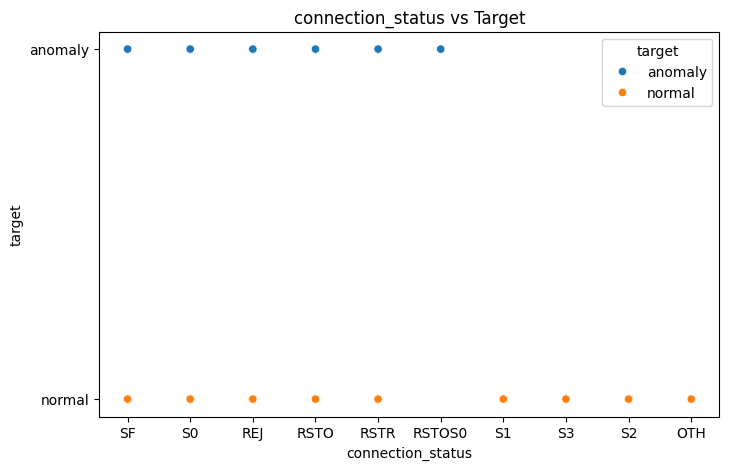

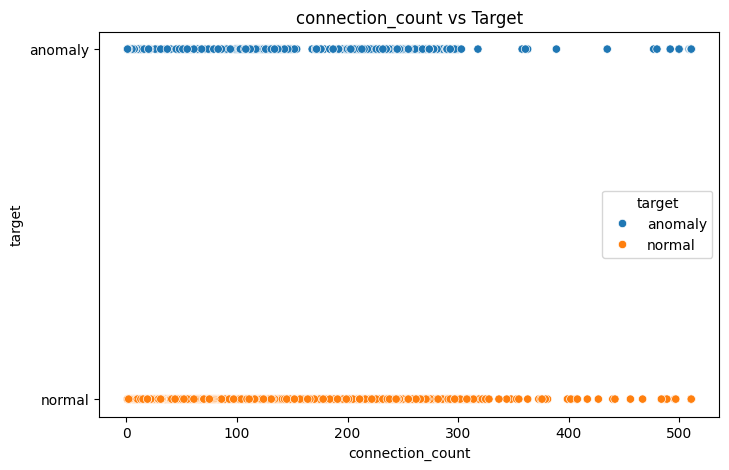

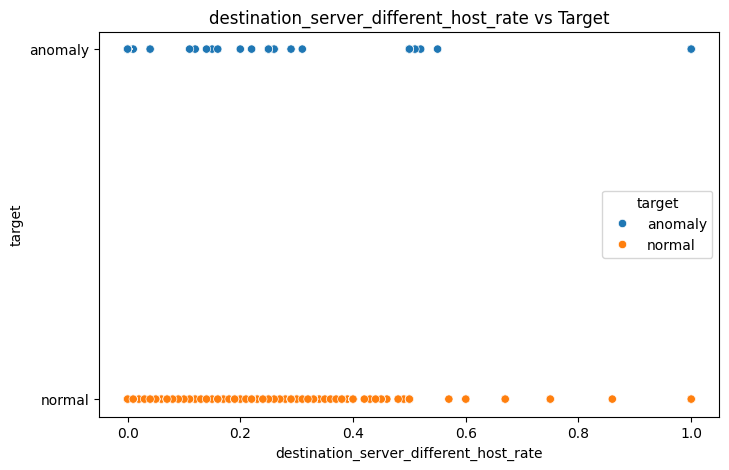

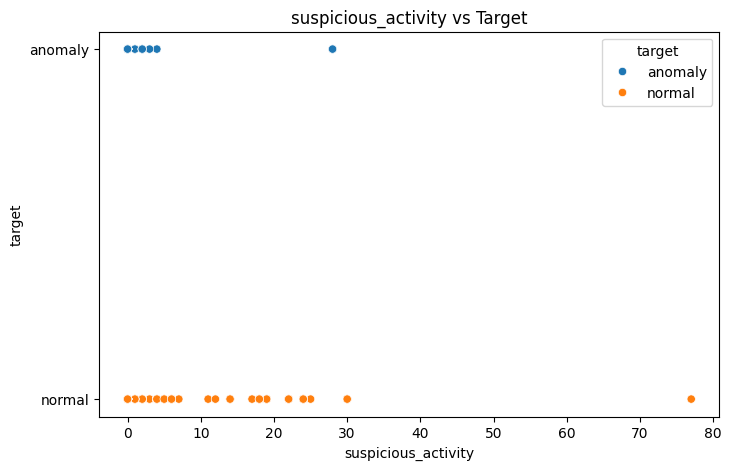

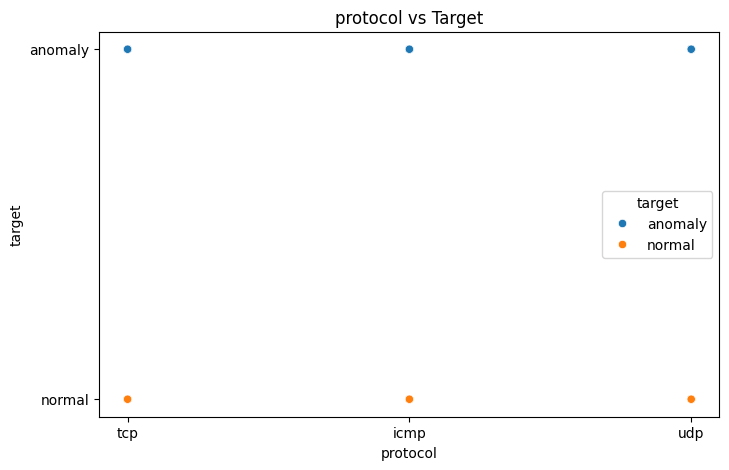

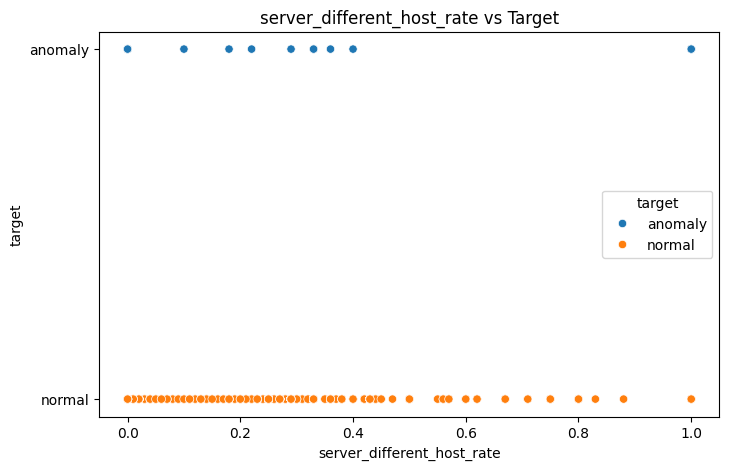

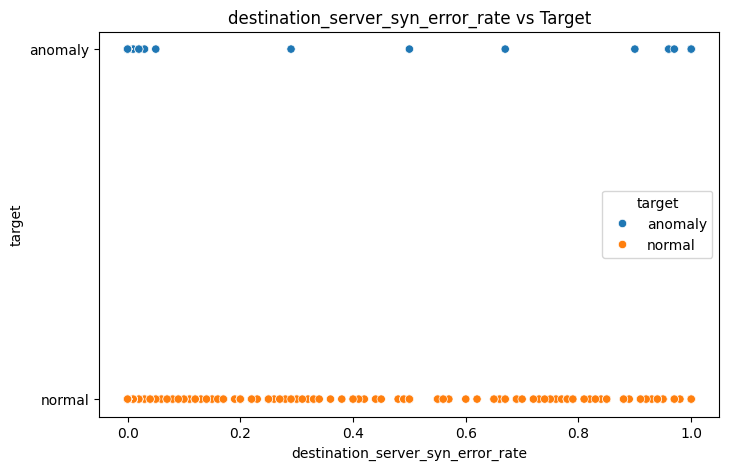

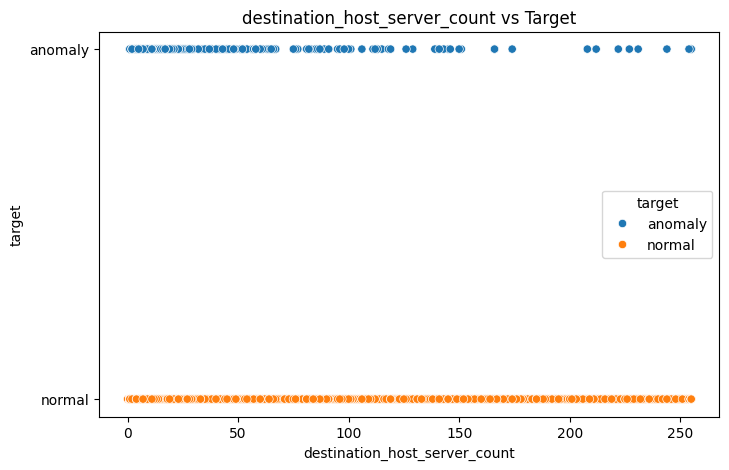

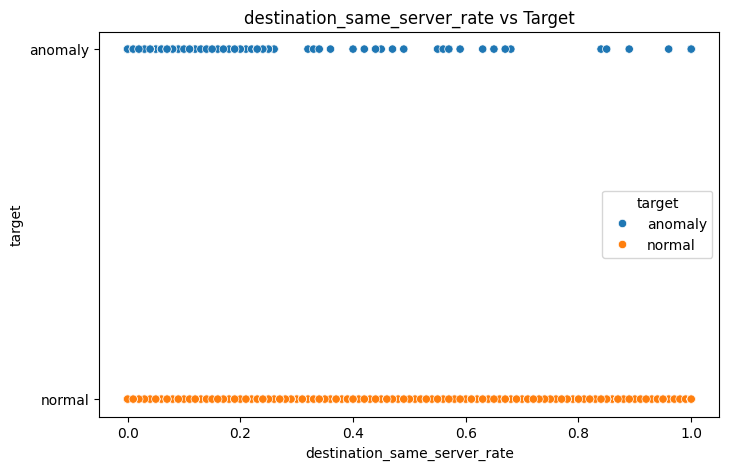

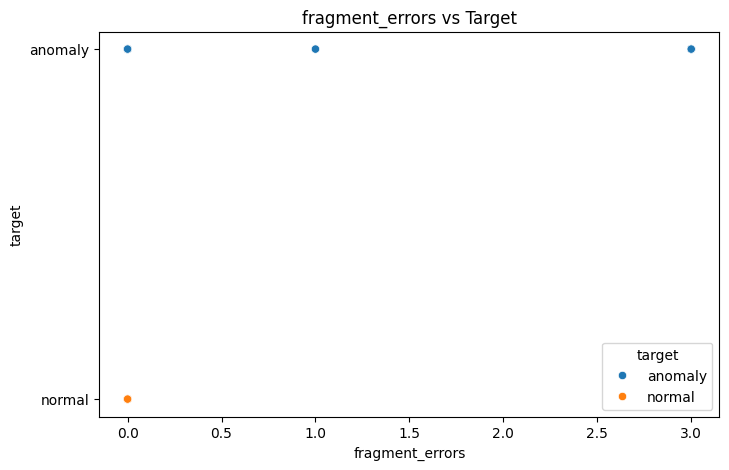

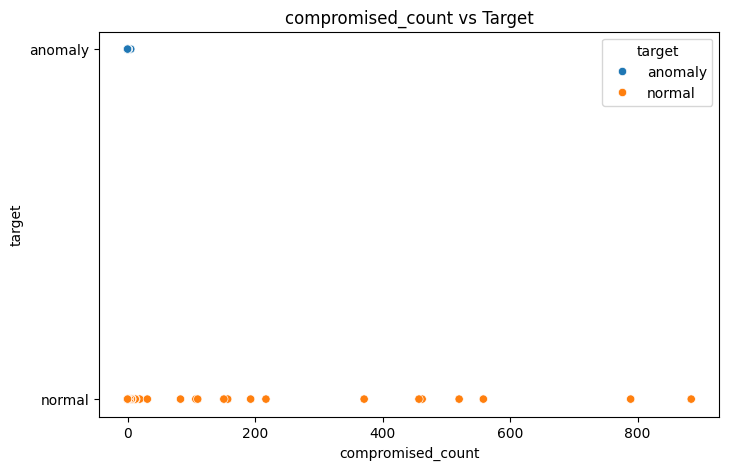

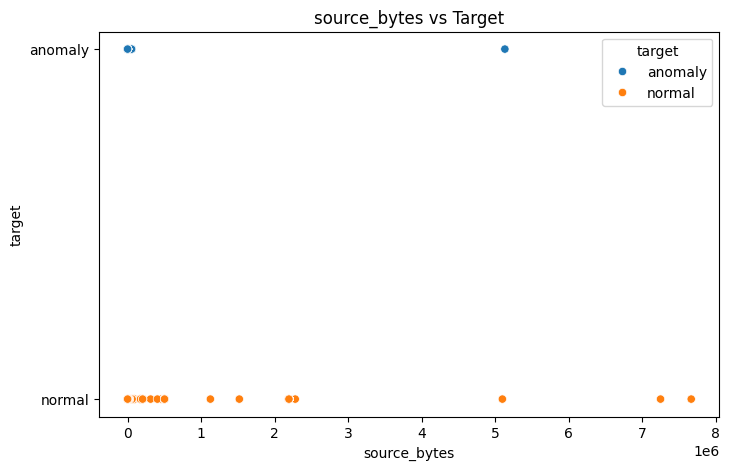

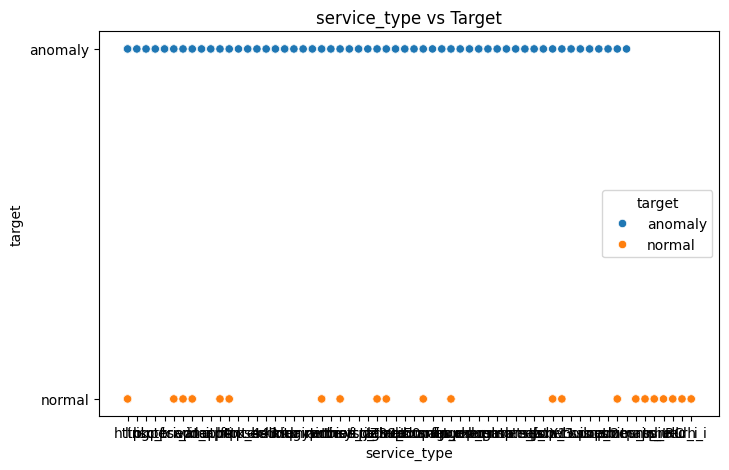

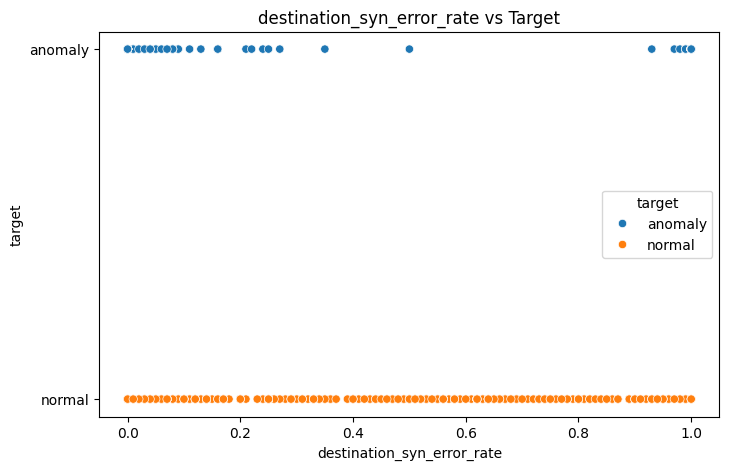

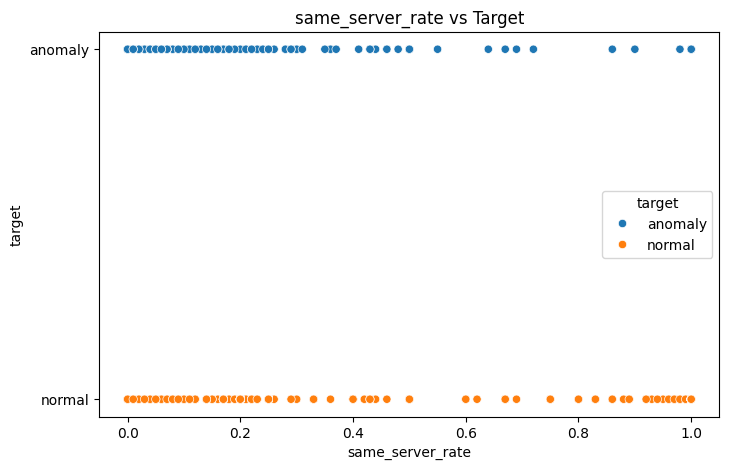

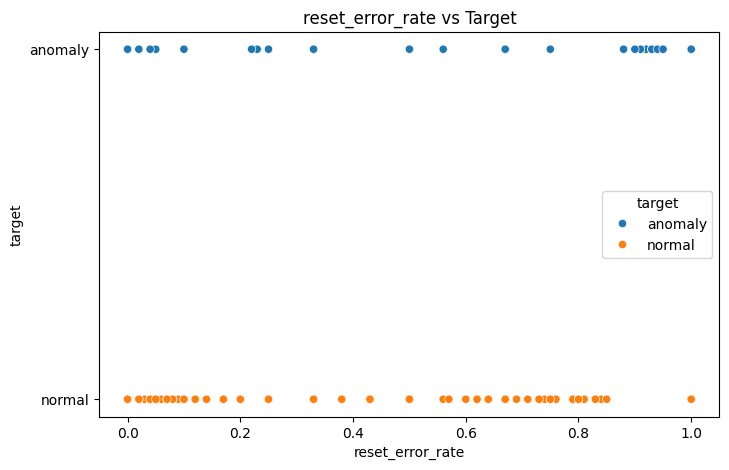

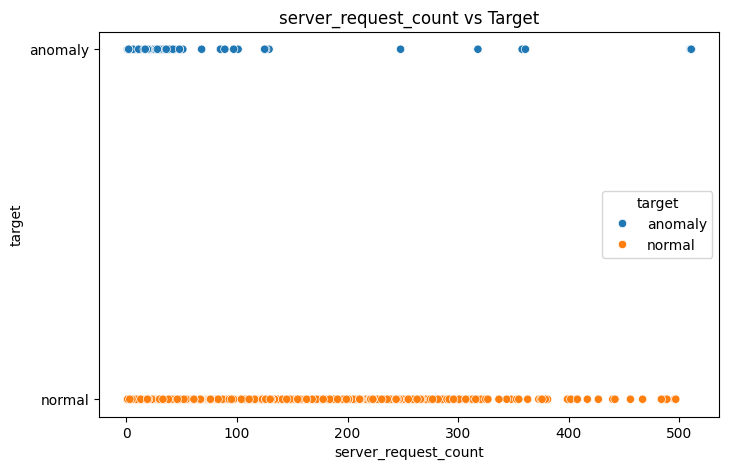

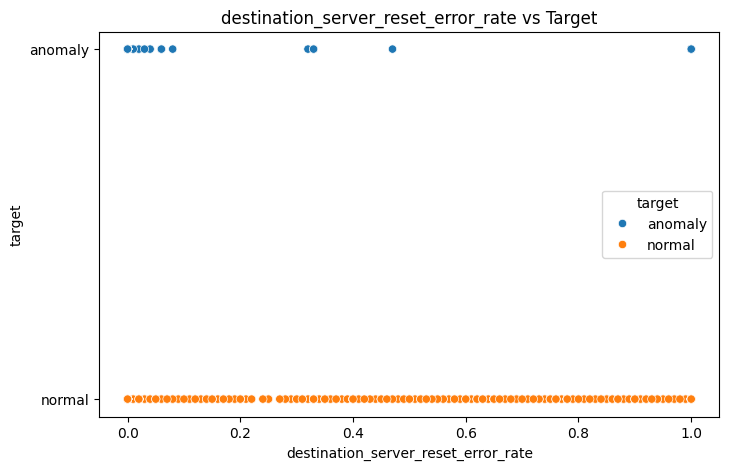

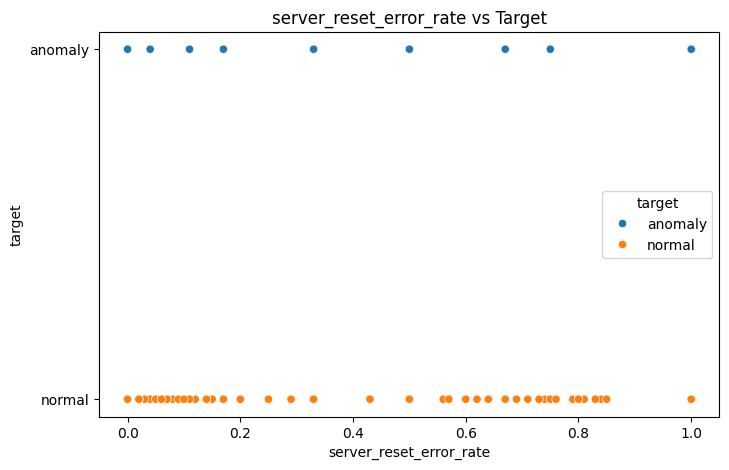

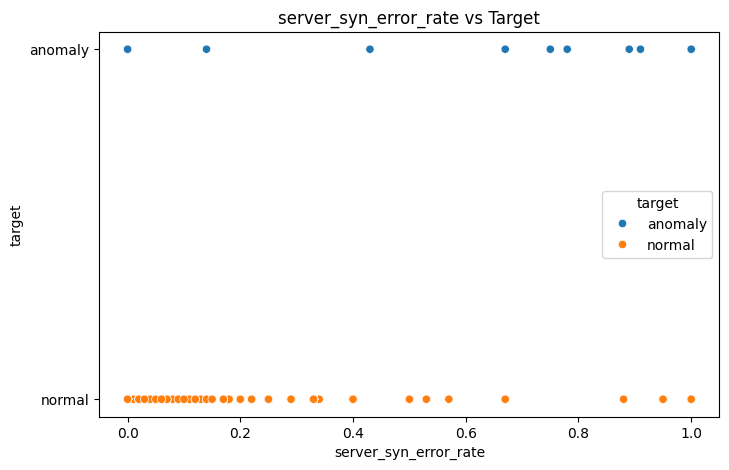

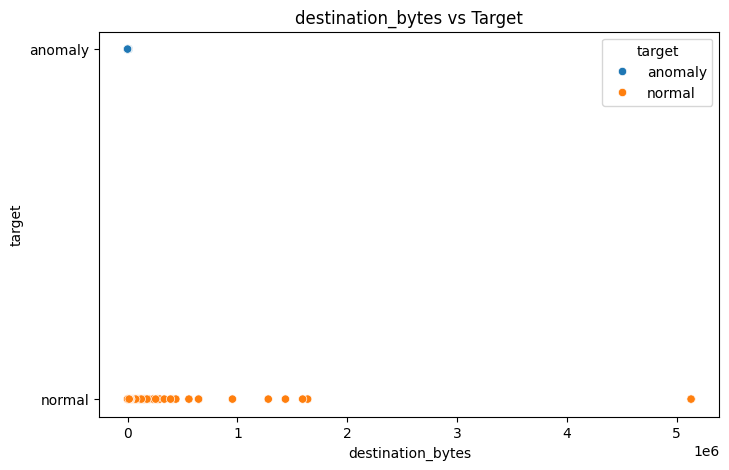

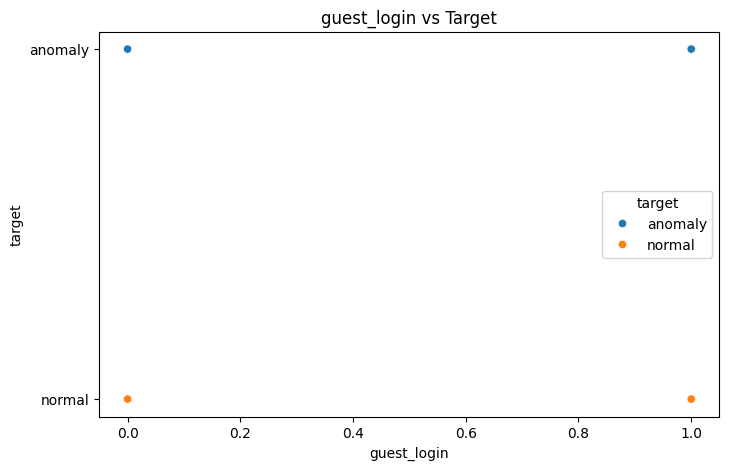

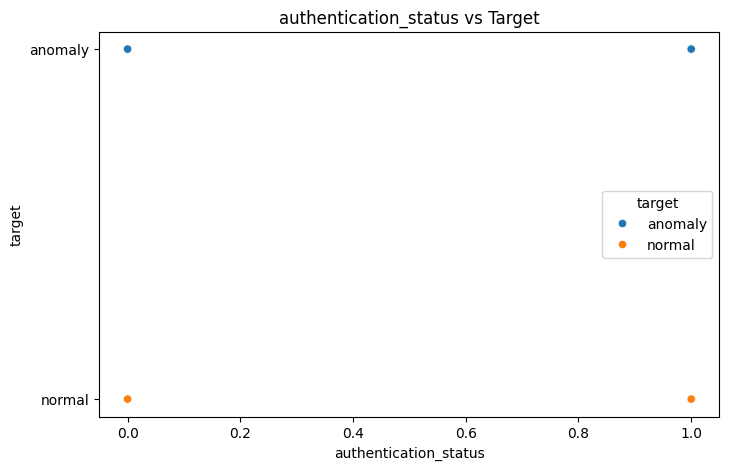

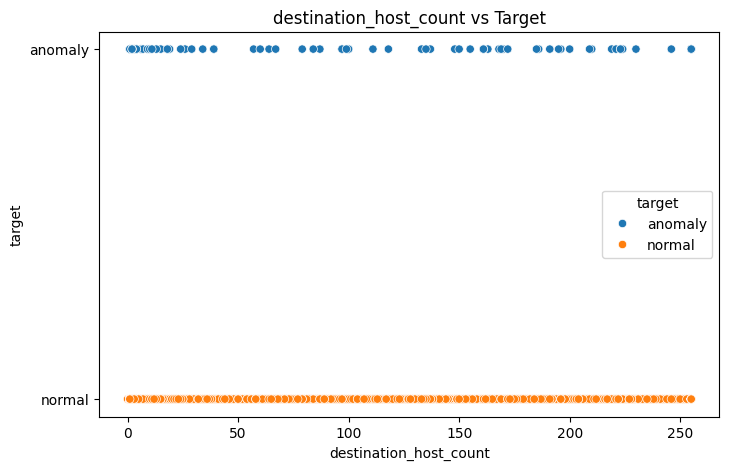

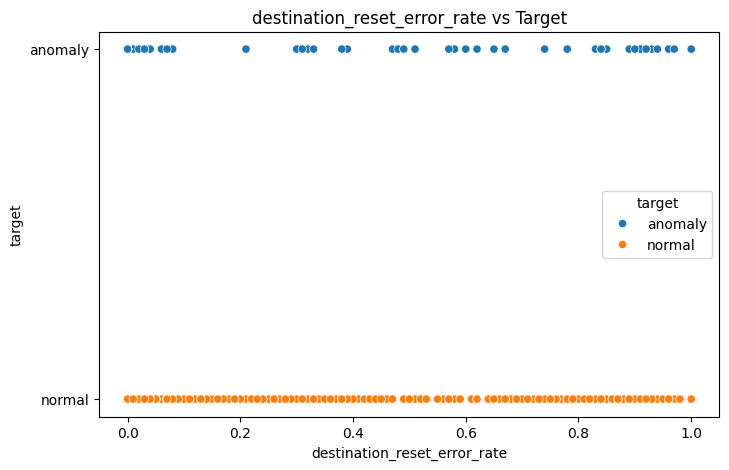

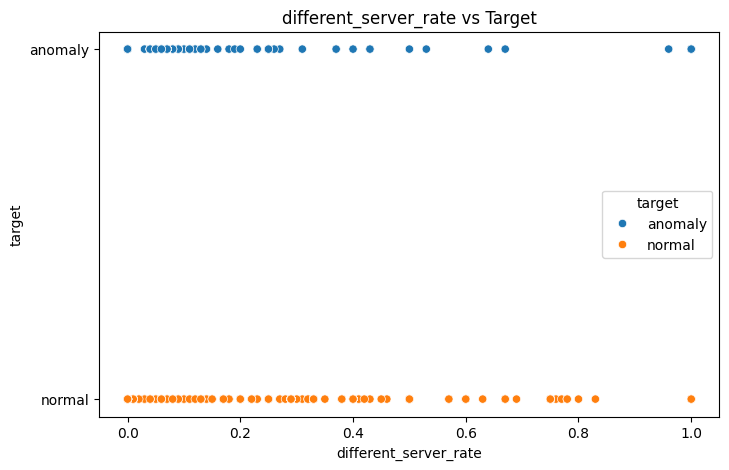

In [21]:
%matplotlib inline

for col in df.columns:
    if col != "target":
        plt.figure(figsize=(8, 5))  # Set figure size for each plot
        sns.scatterplot(x=col, y="target", hue="target", data=df)
        plt.title(f'{col} vs Target')
        plt.show() 


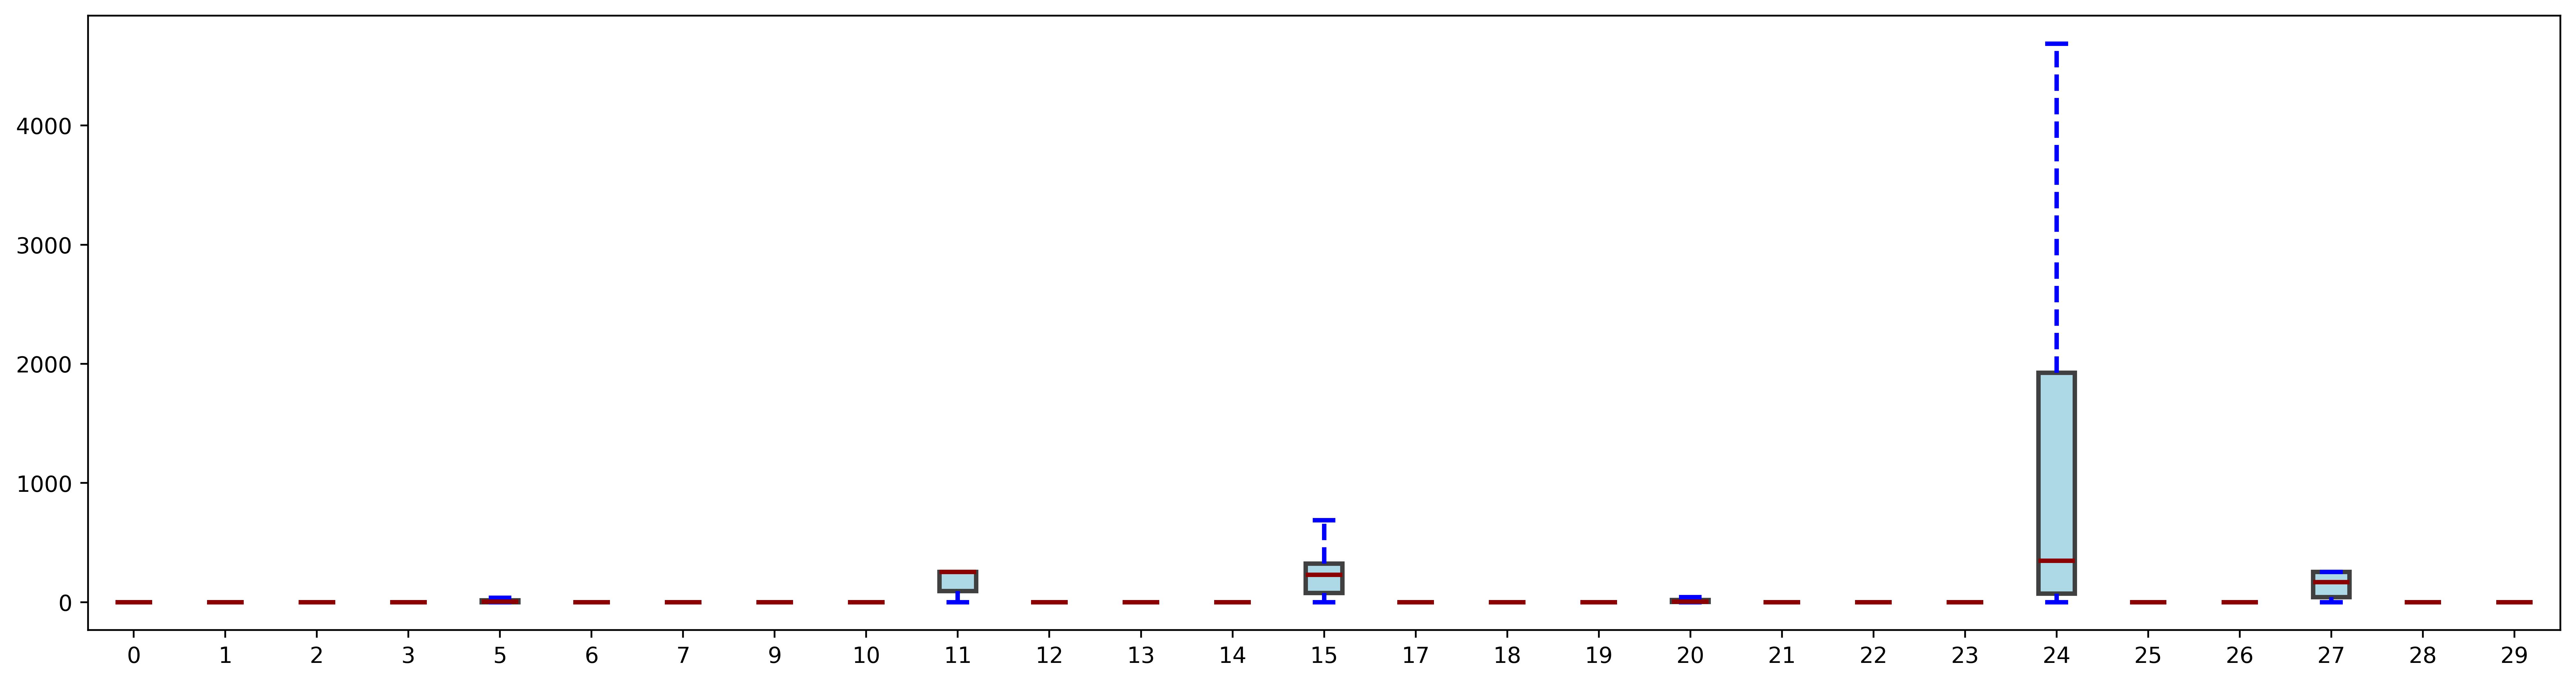

In [20]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=df,
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    gap=1.5
)

plt.show()

In [22]:
[df.columns[11] , df.columns[15] , df.columns[24] , df.columns[27]]

['destination_host_server_count',
 'source_bytes',
 'destination_bytes',
 'destination_host_count']

## Analysis Playground

In [12]:
pyg.walk(df,kernel_computation=True , appearance="dark" , theme_key = "vega")

Box(children=(HTML(value='\n<div id="ifr-pyg-0006325d2b8d8b791FGx9TqRmVgN6epL" style="height: auto">\n    <hea…

## User Defined Functions (UDF)

In [9]:
def skimmer(df:pl.DataFrame)->dict:
    out ={}
    for col in df.columns:
        if(df[col].dtype == pl.Utf8):
            out[f"{col}"] =  {"col_unique_values": df[col].unique().to_list() , "data_type":df[col].dtype}
        else:
            out[f"{col}"] = {"col_values_range": [df[col].min(), df[col].max()],"data_type":df[col].dtype}
    return out

## Data Description



Dataset Schema Explanation:
This dataset appears to describe network connection records, likely for the purpose of network intrusion or anomaly detection. Each record represents a single connection or aggregates statistics about recent connections. Here's a breakdown of the columns (features):
Basic Connection Features:

connection_time:
Data Type: Int64 (Integer)
Range: [0, 41476]
Description: Likely the duration of the connection in seconds or another time unit.


protocol:
Data Type: String (Categorical)
Unique Values: ['udp', 'icmp', 'tcp']
Description: The network protocol used for the connection (UDP, ICMP, TCP).


service_type:
Data Type: String (Categorical)
Unique Values: (List of 60+ services like 'http', 'ftp', 'smtp', 'telnet', 'private', 'other', etc.)
Description: The destination network service (e.g., web, file transfer, email). Some values like 'private' or 'other' suggest a catch-all or unknown service.


connection_status:
Data Type: String (Categorical)
Unique Values: ['SF', 'S1', 'OTH', 'REJ', 'RSTOS0', 'RSTR', 'S3', 'S2', 'S0', 'RSTO']
Description: Represents the status of the connection establishment and termination. These codes often correspond to combinations of TCP flags observed or specific states (e.g., 'SF' likely means Normal establishment and termination, 'REJ' likely means Rejected). This is similar to the 'flag' feature in KDD datasets.


source_bytes:
Data Type: Int64 (Integer)
Range: [0, 7665876]
Description: Number of data bytes sent from the source to the destination.


destination_bytes:
Data Type: Int64 (Integer)
Range: [0, 5131424]
Description: Number of data bytes sent from the destination to the source.



Content/Host-Based Features (Often related to specific behaviors within the connection):

suspicious_activity:
Data Type: Int64 (Integer)
Range: [0, 77]
Description: Count of 'hot' indicators or suspicious actions, like failed login attempts, accessing system control files, etc. Often called 'hot' in KDD datasets.


compromised_count:
Data Type: Int64 (Integer)
Range: [0, 884]
Description: Number of 'compromised' conditions or actions indicating potential system compromise (e.g., gaining root access).


guest_login:
Data Type: Int64 (Integer)
Range: [0, 1]
Description: Binary flag; 1 if the login was a 'guest' login, 0 otherwise.


authentication_status:
Data Type: Int64 (Integer)
Range: [0, 1]
Description: Binary flag; likely 1 if the user successfully logged in, 0 otherwise. Corresponds to logged_in in KDD datasets.


fragment_errors:
Data Type: Int64 (Integer)
Range: [0, 3]
Description: Count of network packets with fragmentation errors. Often called wrong_fragment in KDD datasets.



Time-Based Traffic Features (Statistics over the last ~2 seconds or 100 connections):


These features often look at connections to the same host or the same service within a recent time window.


connection_count:

Data Type: Int64 (Integer)
Range: [1, 511]
Description: Number of connections to the same destination host as the current connection in the past ~2 seconds (or sometimes 100 connections). Corresponds to count in KDD datasets.


server_request_count:
Data Type: Int64 (Integer)
Range: [1, 511]
Description: Number of connections to the same service (port number) as the current connection in the past ~2 seconds. Corresponds to srv_count in KDD datasets.


same_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that were to the same service. Corresponds to same_srv_rate in KDD datasets.


different_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that were to different services. Corresponds to diff_srv_rate in KDD datasets.


server_different_host_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in server_request_count) that were from different source hosts. Corresponds to srv_diff_host_rate in KDD datasets.



Error Rate Features (Time-Based):

syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that had SYN errors (connection initiation errors). Corresponds to serror_rate in KDD datasets.


server_syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in server_request_count) that had SYN errors. Corresponds to srv_serror_rate in KDD datasets.


reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that had RST errors (reset errors). Corresponds to rerror_rate in KDD datasets.


server_reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in server_request_count) that had RST errors. Corresponds to srv_rerror_rate in KDD datasets.



Host-Based Traffic Features (Statistics over the last ~100 connections to the destination host):


These features look at connections based on the destination host, often using a window of the last 100 connections targeting that host.


destination_host_count:

Data Type: Int64 (Integer)
Range: [0, 255]
Description: Number of connections (in the last 100) having the same destination host. Corresponds to dst_host_count in KDD datasets.


destination_host_server_count:
Data Type: Int64 (Integer)
Range: [0, 255]
Description: Number of connections (in the last 100) having the same destination host and using the same service. Corresponds to dst_host_srv_count in KDD datasets.


destination_same_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that were to the same service. Corresponds to dst_host_same_srv_rate in KDD datasets.


destination_different_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that were to different services. Corresponds to dst_host_diff_srv_rate in KDD datasets.


destination_same_source_port_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that were from the same source port. Corresponds to dst_host_same_src_port_rate in KDD datasets.


destination_server_different_host_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_server_count) that were from different source hosts. Corresponds to dst_host_srv_diff_host_rate in KDD datasets.



Error Rate Features (Host-Based):

destination_syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that had SYN errors. Corresponds to dst_host_serror_rate in KDD datasets.


destination_server_syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_server_count) that had SYN errors. Corresponds to dst_host_srv_serror_rate in KDD datasets.


destination_reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that had RST errors. Corresponds to dst_host_rerror_rate in KDD datasets.


destination_server_reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_server_count) that had RST errors. Corresponds to dst_host_srv_rerror_rate in KDD datasets.



Target/Class Label:

class:
Data Type: String (Categorical)
Unique Values: ['normal', 'anomaly']
Description: The classification label for the connection record, indicating whether it's considered normal traffic or an anomaly (potentially an attack).



Likely Origin Dataset:
Based on the feature names (e.g., connection_time -> duration, connection_status -> flag, connection_count -> count, server_request_count -> srv_count, the various _rate features), the types of features (basic connection info, content features, time-based traffic stats, host-based traffic stats), the specific values for categorical features (protocol, service_type, connection_status), and the presence of a class label ('normal', 'anomaly'), this schema strongly matches the KDD Cup 1999 (KDD'99) dataset or its refined version, the NSL-KDD dataset.

KDD Cup 1999: A widely used benchmark dataset for intrusion detection systems, derived from DARPA'98 IDS evaluation data. It contains various simulated attacks mixed with normal traffic.
NSL-KDD: A cleaned-up and improved version of KDD'99, addressing some of its statistical redundancy issues, making it more suitable for evaluating modern IDS.

The feature names in your schema are slightly different but map almost directly to the standard KDD feature names. The class feature being binary ('normal', 'anomaly') is common when using these datasets for binary classification tasks, although the original KDD'99 dataset had more specific attack type labels.


## Handling Unbalanced Target Classes Problem

In [16]:
df["target"].value_counts()

target,count
str,u32
"""anomaly""",587
"""normal""",13449


Text(0.5, 1.0, 'Unbalanced Classes Distribution')

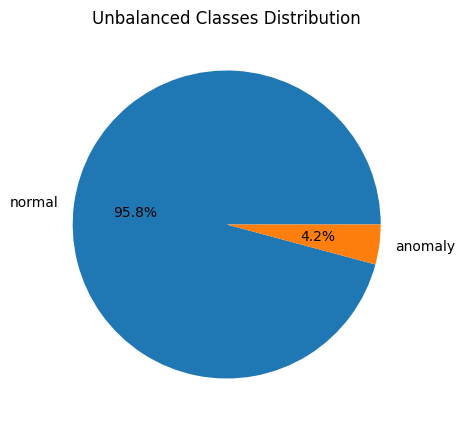

In [20]:
plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x = df["target"].value_counts()["count"] , labels=df["target"].value_counts()["target"] , autopct="%1.1f%%")
plt.title("Unbalanced Classes Distribution")

## Feature Engineering & Selection

In [10]:
# from buckaroo import disable; disable()
scaler = StandardScaler()
X = (df.drop('target').select(cs.numeric()))  # All features except the target
X_scaled = scaler.fit_transform(X) #Data standardization
y = df['target']  # Target variable
f_statistic, p_values = f_classif(X_scaled, y)
data = {"col_name":X.columns,"f_statistic": f_statistic, "p_values": p_values }
annova = pl.DataFrame(data)
filtered_annova = annova.filter((pl.col("p_values") <= 0.05 )& (pl.col("f_statistic") >= pl.mean("f_statistic") - 2200)) #Manual testing for values
mostCoRELATED = filtered_annova['col_name'].to_list()
filtered_annova


col_name,f_statistic,p_values
str,f64,f64
"""syn_error_rate""",10571.025841,0.0
"""connection_count""",2848.992744,0.0
"""destination_server_syn_error_r…",14813.838093,0.0
"""destination_host_server_count""",1743.53087,0.0
"""destination_same_server_rate""",2092.916738,0.0
"""destination_syn_error_rate""",10941.375787,0.0
"""same_server_rate""",9530.965368,0.0
"""server_syn_error_rate""",11419.807349,0.0
"""authentication_status""",1252.844566,6.0988e-263


In [149]:
selector = SelectKBest(score_func=f_classif, k=30) #Validating the feature selection

X_new = selector.fit_transform(X_scaled, y)

selected_indices = selector.get_support(indices=True)
print(selected_indices)
selected_features = [X.columns[i] for i in selected_indices]
print("\nSelected features: \n", selected_features)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]

Selected features: 
 ['syn_error_rate', 'connection_time', 'destination_same_source_port_rate', 'destination_different_server_rate', 'connection_count', 'destination_server_different_host_rate', 'suspicious_activity', 'server_different_host_rate', 'destination_server_syn_error_rate', 'destination_host_server_count', 'destination_same_server_rate', 'fragment_errors', 'compromised_count', 'source_bytes', 'destination_syn_error_rate', 'same_server_rate', 'reset_error_rate', 'server_request_count', 'destination_server_reset_error_rate', 'server_reset_error_rate', 'server_syn_error_rate', 'destination_bytes', 'guest_login', 'authentication_status', 'destination_host_count', 'destination_reset_error_rate', 'different_server_rate']


In [156]:
if mostCoRELATED == selected_features:
    print(True)
else:
    mostCoRELATED = selected_features

True


In [154]:
#https://medium.com/aiskunks/categorical-data-encoding-techniques-d6296697a40f
for col in df.select(pl.col(pl.Utf8)): 
    if col.name =="target":
        continue
    contingency_df = ( #building contingency tables , https://docs.pola.rs/api/python/stable/reference/dataframe/api/polars.DataFrame.pivot.html
        df.group_by([col.name, "target"])
        .agg(pl.len().alias("count"))
        .pivot(
            values="count",
            index=col.name,
            on="target",
            aggregate_function="sum"
        )
        .fill_null(0)  # Fill missing combinations with 0
    ).drop(col.name).to_numpy().astype(int) # drop  feature column  and convert only counts to a numpy array
    correlation = association(contingency_df, method="cramer") # calculate Cramér's V association between the feature and target
    if(correlation>0.6 ):
        print(col.name , col.unique().shape[0] ,"       ", correlation)
        if( col.name  not in mostCoRELATED):
            mostCoRELATED.append(col.name)

connection_status 10         0.7204663984193229
service_type 62         0.7445614132065677


In [155]:
len(mostCoRELATED)

29

In [147]:
features = df[mostCoRELATED].to_pandas()
features = pd.get_dummies(data = features , dtype = int)
featuresSCALED = scaler.fit_transform(features) 
PCA_featuresSCALED = PCA(n_components=2).fit_transform(featuresSCALED)
PCA_featuresSCALED_WITH_Target = pl.DataFrame({"comp1":PCA_featuresSCALED[:,0] , "comp2":PCA_featuresSCALED[:,0] , "label":df["target"]})
print(PCA_featuresSCALED.shape)

(14036, 2)


In [20]:
PCA_featuresSCALED_WITH_Target

comp1,comp2,label
f64,f64,str
-0.93753,-0.93753,"""anomaly"""
14.900029,14.900029,"""anomaly"""
14.755916,14.755916,"""anomaly"""
14.89159,14.89159,"""anomaly"""
14.745531,14.745531,"""anomaly"""
…,…,…
0.530796,0.530796,"""normal"""
-1.104681,-1.104681,"""normal"""
0.180037,0.180037,"""normal"""


## Testing SMOTE VS ADASYN

In [12]:
#I'm using oversampling as undersampling works by removing samples of the majority class and I don't want to lose any data
#https://medium.com/@abdallahashraf90x/oversampling-for-better-machine-learning-with-imbalanced-data-68f9b5ac2696
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
"""
We need to know which 1 will be working good with the data and why?
RandomOverSampler
SMOTE
SMOTENC prefered
SMOTEN
ADASYN
BorderlineSMOTE
KMeansSMOTE
SVMSMOTE
"""

'\nWe need to know which 1 will be working good with the data and why?\nRandomOverSampler\nSMOTE\nSMOTENC prefered\nSMOTEN\nADASYN\nBorderlineSMOTE\nKMeansSMOTE\nSVMSMOTE\n'

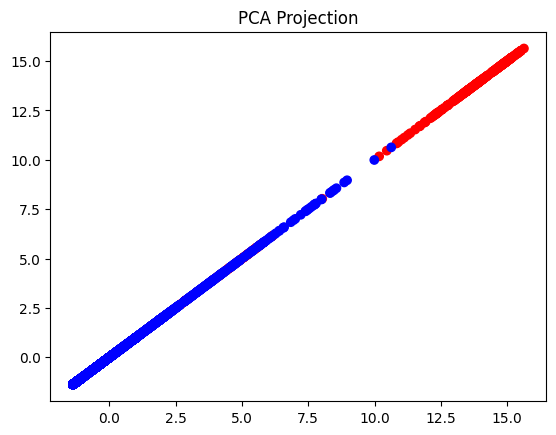

In [36]:
colorsMAP = {"anomaly":"red"  , "normal":"blue"}
plt.scatter(PCA_featuresSCALED_WITH_Target["comp1"],
            PCA_featuresSCALED_WITH_Target["comp2"] ,
            c = df["target"].replace(colorsMAP)
           ) #https://stackoverflow.com/questions/74779644/mapping-a-python-dict-to-a-polars-series , https://kanoki.org/2020/08/30/matplotlib-scatter-plot-color-by-category-in-python/
plt.title("PCA Projection")
plt.show()

In [34]:
# PCA_featuresSCALED_WITH_Target
# PCA_featuresSCALED.shape 
tsne_data.shape

(14036, 2)

In [37]:
# https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d 
# https://dev.to/sreeni5018/pca-vs-t-sne-unveiling-the-best-dimensionality-reduction-technique-for-your-data-ekc

tsne = TSNE(n_components=2) #data - reduction 
tsne_data = tsne.fit_transform(featuresSCALED)

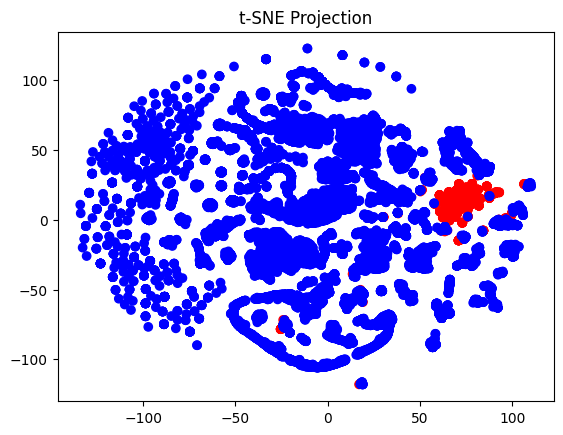

In [38]:
plt.scatter(tsne_data[:, 0], tsne_data[:, 1] , c = df["target"].replace(colorsMAP))
plt.title("t-SNE Projection")
plt.show()


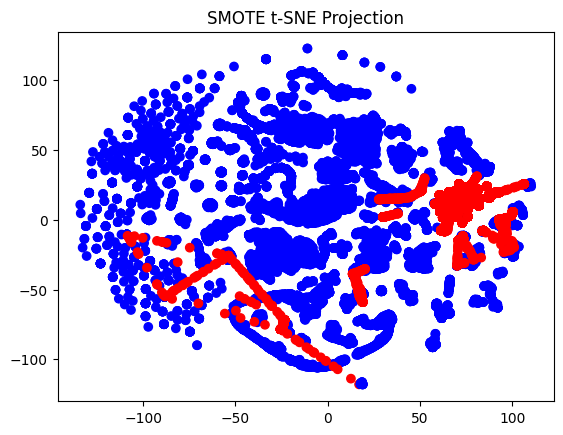

In [40]:
X_resampled, y_resampled = SMOTE().fit_resample(tsne_data, df["target"])

plt.scatter(X_resampled[:, 0], X_resampled[:, 1] , c = y_resampled.replace(colorsMAP))
plt.title("SMOTE t-SNE Projection")
plt.show()

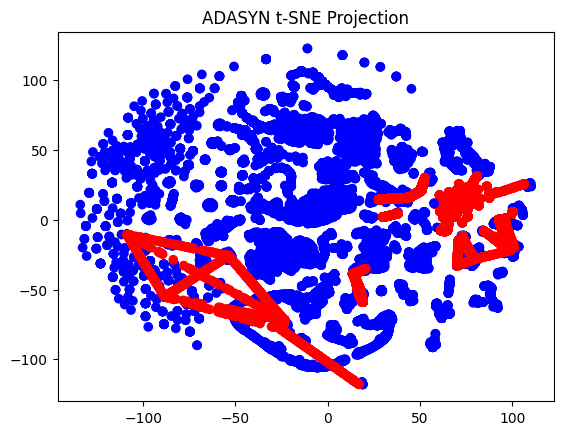

In [86]:
X_resampled, y_resampled = ADASYN().fit_resample(tsne_data, df["target"])


plt.scatter(X_resampled[:, 0], X_resampled[:, 1] , c = y_resampled.replace(colorsMAP))
plt.title("ADASYN t-SNE Projection")
plt.show()

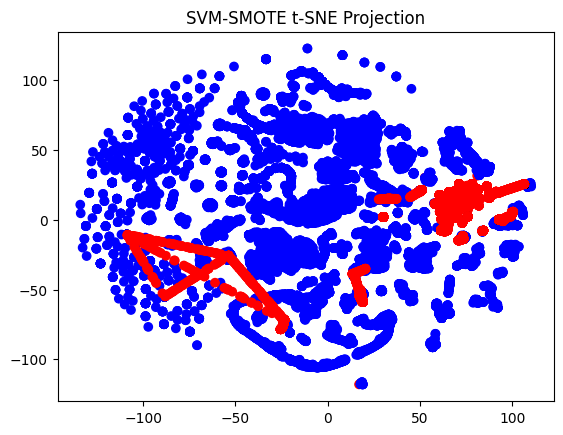

In [88]:
X_resampled, y_resampled = SVMSMOTE().fit_resample(tsne_data, df["target"])


plt.scatter(X_resampled[:, 0], X_resampled[:, 1] , c = y_resampled.replace(colorsMAP))
plt.title("SVM-SMOTE t-SNE Projection")
plt.show()

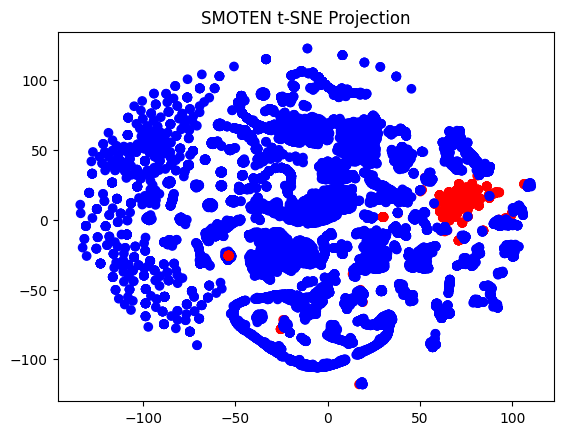

In [94]:
X_resampled, y_resampled = SMOTEN().fit_resample(tsne_data, df["target"])


plt.scatter(X_resampled[:, 0], X_resampled[:, 1] , c = y_resampled.replace(colorsMAP))
plt.title("SMOTEN t-SNE Projection")
plt.show()

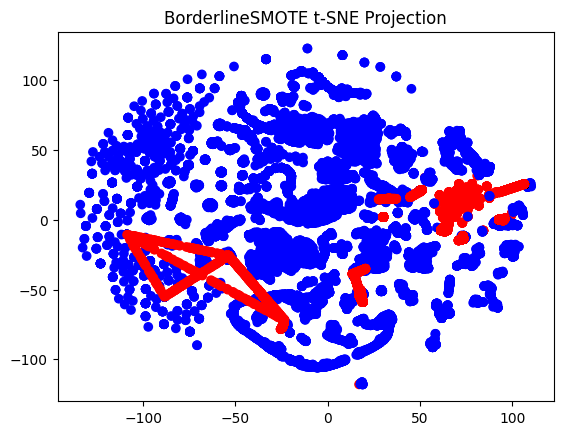

In [90]:
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(tsne_data, PCA_featuresSCALED_WITH_Target["label"])


plt.scatter(X_resampled[:, 0], X_resampled[:, 1] , c = y_resampled.replace(colorsMAP))
plt.title("BorderlineSMOTE t-SNE Projection")
plt.show()

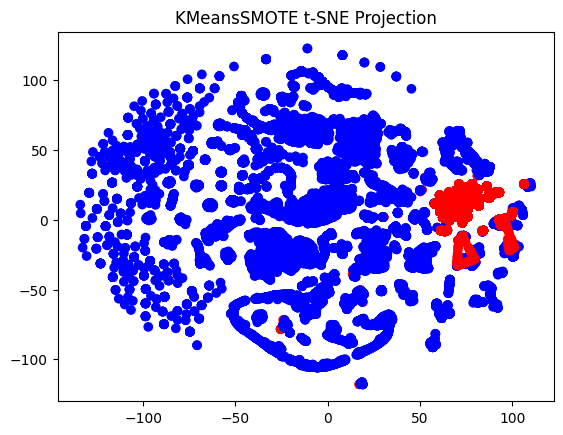

In [92]:
X_resampled, y_resampled = KMeansSMOTE(cluster_balance_threshold =0.2).fit_resample(tsne_data, df["target"] )

plt.scatter(X_resampled[:, 0], X_resampled[:, 1] , c = y_resampled.replace(colorsMAP))
plt.title("KMeansSMOTE t-SNE Projection")
X
plt.show()

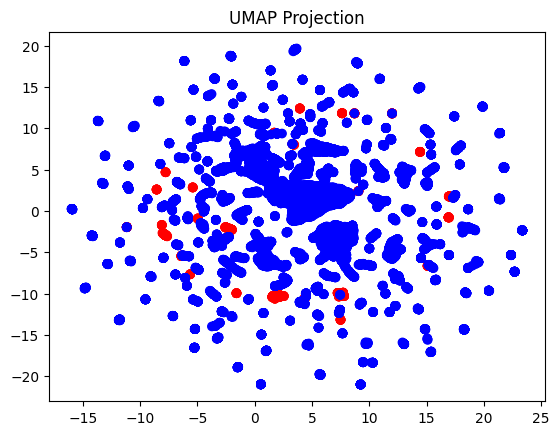

In [80]:
import umap
# https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d  , https://www.reddit.com/r/datascience/comments/wy1rmk/pca_vs_umap_vs_tsne_on_a_very_layman_level_what/
# https://medium.com/@aastha.code/dimensionality-reduction-pca-t-sne-and-umap-41d499da2df2
umap_model = umap.UMAP(n_components=2)
umap_data = umap_model.fit_transform(featuresSCALED)

plt.scatter(umap_data[:, 0], umap_data[:, 1] , 
           c =  df["target"].replace(colorsMAP)
           )
plt.title("UMAP Projection")
plt.show()


## Exporting Datasets After Solving Classes Un-balance

In [95]:
#just for testing ignore it
pd.concat([pd.DataFrame(X_resampled) , y_resampled]  , axis=1 , ignore_index=True).to_csv("data/KMeansSMOTE_Reduced.csv", index=False)
# type(X_resampled) ,type( y_resampled)

In [159]:
featuresSCALED.shape

(14036, 97)

In [160]:
#Chosen KMeansSMOTE
# ------------------ SMOTEN on selected scaled features ------------------

# Apply SMOTEN 
X_resampled, y_resampled = SMOTEN().fit_resample(featuresSCALED, df["target"])

# Combine resampled features and target 
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled)], axis=1)

# to  CSV 
resampled_df.to_csv("data/KMeansSMOTE_Y_SelectedFeatures.csv", index=False)

In [163]:

#------------------ KMEAN-SMOTE on manually selected features ------------------

# Load dataset
O_M_CF = pd.read_csv("data/chosen_features.csv")

# Apply SMOTEN
X_resampled, y_resampled = SMOTEN().fit_resample(O_M_CF.drop(columns=["class"]), O_M_CF["class"])

resampled_df_manual = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled)], axis=1)

# Save CSV 
resampled_df_manual.to_csv("data/KMeansSMOTE_O_M_SelectedFeatures.csv", index=False)

## SyntaxTesting

In [ ]:
df["protocol"].unique()

In [ ]:
df.select(cs.string()).unique()

In [ ]:
html = strip_markdown("#your_text_string\nt")
print(html)

In [ ]:
df["connection_count"].plot.hist()

In [ ]:
df["target"]